In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xarray as xr

### Data Input

In [181]:
#load data
d = pd.read_csv('rab5traj.csv')

uid = np.unique(d['pid'])
data = d[d['pid']==11]

data_xr = data.to_xarray()

def downsample_xr(data_in,down_int):
    ds_coords = np.arange(down_int)
    for i in ds_coords:
        
        data_ds = data_in.isel(index=slice(i,-1,down_int))
        print(data_ds)
        if i == 0:
            data_out_xr = data_ds
            data_out_xr.expand_dims("ds")
        else:
            data_out_xr = xr.concat((data_out_xr,data_ds),"ds")
            
    data_out_xr = data_out_xr.assign_coords({"ds":ds_coords})
    
    return data_out_xr
    
def downsample(data_input,down_int,start_index=0):
    
    for i in np.arange(down_int):
        data_out = data_input.iloc[start_index::down_int]
    return data_out


#data_xr_ds = downsample_xr(data_xr,10)

#x_xr = data_xr_ds['x']
#y_xr = data_xr_ds['y']
#t_xr = data_xr_ds['t']

data_ds = downsample(data,2,0)

x = np.array(data_ds['x'])
y = np.array(data_ds['y'])
t = np.array(data_ds['t'])  

len(data['t'])//2

399

### Displacements and exponent prediction

In [138]:
#load neural network model
model = tf.keras.models.load_model("model3dense_n20.h5")

def find_displacement(x_data,y_data,start_index=0):
#calculate displacements
    #x_data = np.array(x_data.data)
    #y_data = np.array(y_data.data)
    disps = np.sqrt(np.power(x_data-x_data[0],2) + np.power(y_data-y_data[0],2))
    
    return disps 

def assign_displacement(d_in_xr):
    
    disps = np.sqrt(np.power(d_in_xr['x']-d_in_xr['x'].isel(ds=0,index=0),2) 
            + np.power(d_in_xr['y']-d_in_xr['y'].isel(ds=0,index=0),2))
    d_out_xr = d_in_xr.assign(displacements=disps)
    
    return d_out_xr
    
def estimate_hurst_xr(disps,data_in):
#loop through the data points and estimate the hurst exponent in every window of 20 points
    disps = disps[~np.isnan(disps)]
    print(len(disps))
    t_xr = data_in['t']
    h = np.array([])
    ht = np.array([])
    for i in range(10,len(disps)-11):
        #sample of 20 points to calculate hurst exponent for
        inx = disps[(i-10):(i+11)]
        #apply differencing and normalization on the data
        inx = np.array([(inx[1:]-inx[0:-1])/(np.amax(inx)-np.amin(inx))])
        test = model.predict(inx,verbose=0)
        h=np.append(h,test[0][0])
        t=t_xr.isel(index=i).data
        if np.isnan(t)==False:
            ht = np.append(ht,t)
        
    return h,ht

def estimate_hurst(disps,time):
    
    h = np.array([])
    ht = np.array([])
    for i in range(10,len(disps)-11):
        #sample of 20 points to calculate hurst exponent for
        inx = disps[(i-10):(i+11)]
        #apply differencing and normalization on the data
        inx = np.array([(inx[1:]-inx[0:-1])/(np.amax(inx)-np.amin(inx))])
        test = model.predict(inx,verbose=0)
        h=np.append(h,test[0][0])
        ht = np.append(ht,time[i])
        
    return h,ht

displacements = find_displacement(x,y)
h,ht = estimate_hurst(displacements,t)

In [140]:
def dsample_estimate_hurst(data_in,ds_rate):
    
    h_estimates = np.empty((ds_rate,len(data_in)//ds_rate))

    for i in np.arange(ds_rate):
        
        downsampled_data = downsample(data_in,ds_rate,i)
        displacements = find_displacements
        
        
        
    
    
    
    

379

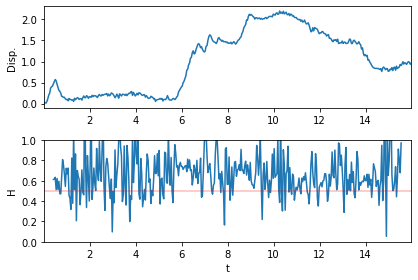

In [141]:
#plot displacements
plt.figure()
plt.subplot(211)
plt.plot(t,displacements)
plt.ylabel('Disp.')
plt.xlim([t[0],t[-1]])
plt.subplot(212)
plt.plot(ht,h)
plt.plot([t[0],t[-1]],[0.5,0.5],'r-',lw=0.4)
plt.ylabel('H')
plt.xlabel('t')
plt.xlim(t[0],t[-1])
plt.ylim(0,1)
plt.tight_layout()
plt.show()

In [143]:
data_1 = downsample(data,15,0)
data_2 = downsample(data,15,7)

print(data_1)
print(data_2)

disp=find_displacement(np.array(data['x']),np.array(data['y']))
disp_1 = find_displacement(np.array(data_1['x']),np.array(data_1['y']))
disp_2 = find_displacement(np.array(data_2['x']),np.array(data_2['y']))

h0,ht0=estimate_hurst(disp,data)
h1,ht1=estimate_hurst(disp_1,data_1)
h2,ht2=estimate_hurst(disp_2,data_2)

     pid         x          y      t         r      Ibg    Ipeak
0     11  3.461135  17.593507   0.02  0.347013  127.898  190.320
15    11  3.231333  17.300804   0.32  0.325318  127.124  193.572
30    11  3.210708  17.303214   0.62  0.357009  126.331  183.990
45    11  3.397124  17.496358   0.92  0.342458  127.735  193.220
60    11  3.440574  17.515536   1.22  0.320031  127.042  195.522
75    11  3.381803  17.562801   1.52  0.345136  127.435  188.578
90    11  3.340921  17.523501   1.82  0.309056  126.760  194.232
105   11  3.319531  17.481896   2.12  0.329107  126.276  186.674
120   11  3.270244  17.489966   2.42  0.326562  126.251  192.783
135   11  3.285922  17.463556   2.72  0.321012  125.942  189.108
150   11  3.288658  17.458945   3.02  0.335689  125.520  185.826
165   11  3.395636  17.403611   3.32  0.347113  125.064  186.312
180   11  3.351023  17.439977   3.62  0.366455  124.711  175.904
195   11  3.368850  17.380136   3.92  0.334523  124.527  183.454
210   11  3.337756  17.39

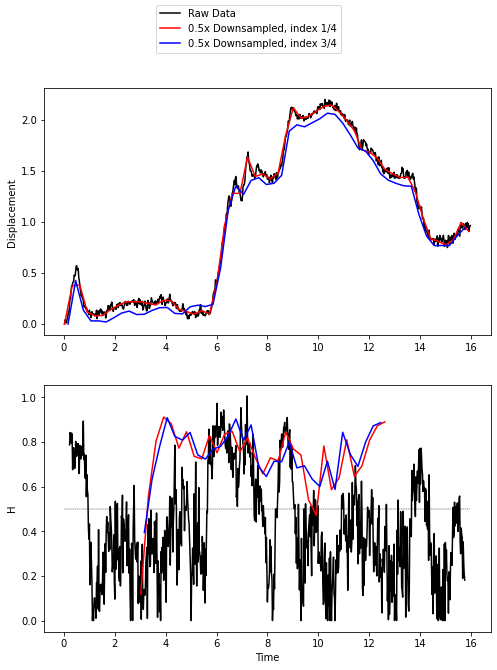

In [144]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,10))
ax1.plot(data['t'],disp,color='k',label='Raw Data')
ax1.plot(data_1['t'],disp_1,color='r',label='0.5x Downsampled, index 1/4')
ax1.plot(data_2['t'],disp_2,color='b',label='0.5x Downsampled, index 3/4')
ax1.set_ylabel('Displacement')
ax2.plot(ht0,h0,color='k')
ax2.plot(ht1,h1,color='r')
ax2.plot(ht2,h2,color='b')
ax2.plot([t[0],t[-1]],[0.5,0.5],'k--',lw=0.4)
ax2.set_ylabel('H')
ax2.set_xlabel('Time')
fig.legend(loc='upper center')

### Meeting notes with t.waigh and Jacob, 13/10
- prob spectrum of alpha vs alpha (p(h) vs h)
- then compare as the time sampling gets coarser
- directed and undirected, so when time is coarser it just takes teh directed component, as these are the flight parts
- wavenet instead of just normal neural network - good for long range correlation
-working with data, i.e. plotting etc 
- work in depth with the repeats 
-essential cell biology, first chapter is decent
-physical biology of the cell 
-active matter within and around us 

3pm meeting next week

## workplan with Mila for 13/10-20/10:
Reading ( suggestions ):
- finish section 6 or general reading in ML book
- read some stuff from the CNN section 
- Physical cell biology book 
- github (?)
Coding:
Main:
- streamline the exist downsampling to set it up for doing multiple runs ( different coarseness ) (paul) (before tuesday)
- Do the p(h) vs h plot for a single case ( together, Tuesday ) read before from the github 
- Plot the 3D plots from the data
- Plot P(h) vs h for multiple sampling times, 3D plot
Extra:
- tinker with the NN layers and layer widths

### Main Thing for before tuesday:
### Read about p(h) vs h, how does dan do it in his github?